In [1]:
%load_ext autoreload
%autoreload 2
#  base environment
from notebook_setup import *

import os
import dotenv
import numpy as np
import functools

# noise generation
from noise import pnoise2, pnoise3
from joblib import Parallel, delayed

# visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings

# load environment variables
_ = dotenv.load_dotenv(override=True)

from training.networks.neuraloperator.multipole import MPGKScoreOperator
from data.synthetic.low_frequency import PinkNoise1D
from training.noising_kernels import RBFIrregular
from training.collate import CollateMesh, CompositeCollate, MakeConditional
from training.networks.neuraloperator.multipole import MPGKScoreOperator
from training.loss import EDMLoss

# Testing the Denoising Network

Diffusion models on function space, all rely on a denoising score operator. Here, we test our multipole score operator on a simple 1D example as a sanity check.

For a denoising operator, we first define a simple family of 1D functions. Here, we consider functions originating from a pink noise process composed with a low-pass filter to model functions with global low-frequency characteristics. The following code first samples from this stochastic process and visualizes the functions.


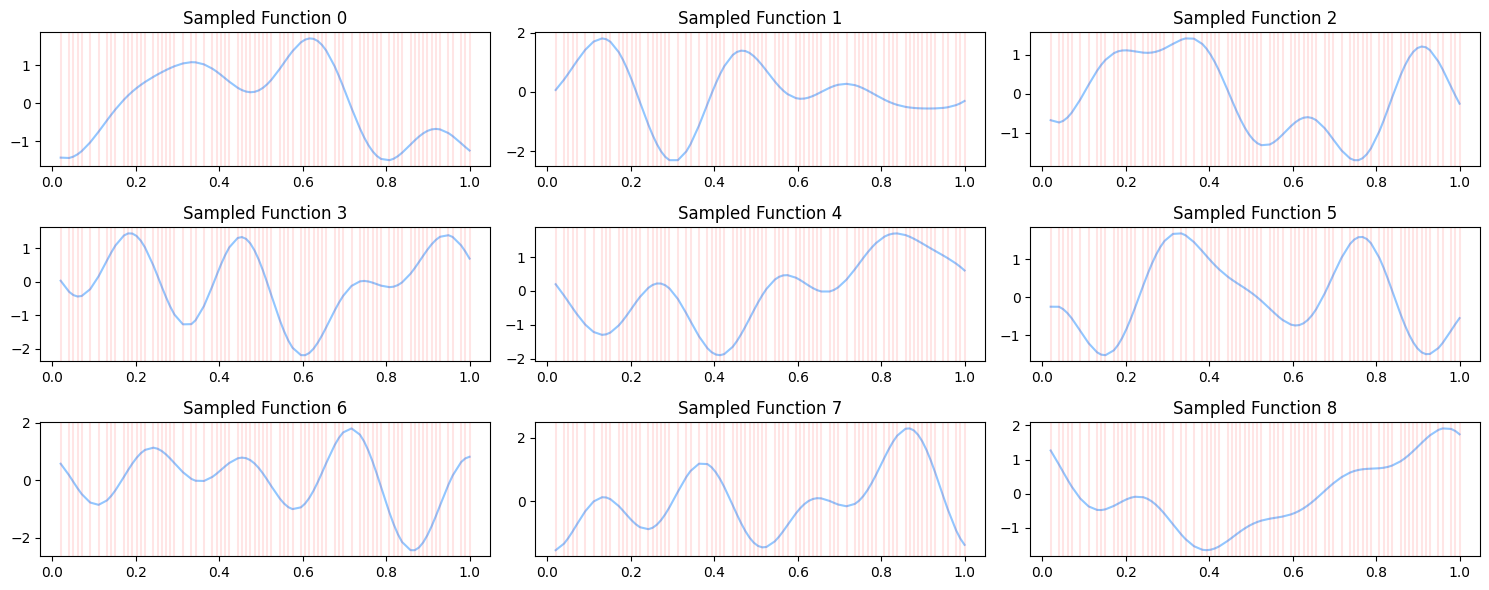

In [2]:
dset = PinkNoise1D(
    total_count=1000,
    num_samples=100,
    low_pass_threshold=0.05,
    make_irregular=True,
    bernoulli_p=0.8,
    fixed_irregularity_seed=42,
)
# plot 9 first samples of the dataset
fig, axes = plt.subplots(3, 3, figsize=(15, 6))
for i in range(9):
    ax = axes[i // 3, i % 3]
    coords, intensities = dset[i]
    ax.plot(coords.squeeze(), intensities.squeeze())
    ax.set_title(f"Sampled Function {i}")
    # add small vertical lines on each coords 
    for x in coords.squeeze():
        ax.axvline(x, color="red", alpha=0.1)
plt.tight_layout()

To train a denoising operator, we must first define our noising operator. Here, we pick an RBF noising kernel with a scale $\sigma$ to turn the base stochastic process into a Gaussian process. The resulting functions as they are being noised out are also plotted in the following using irregular grids:


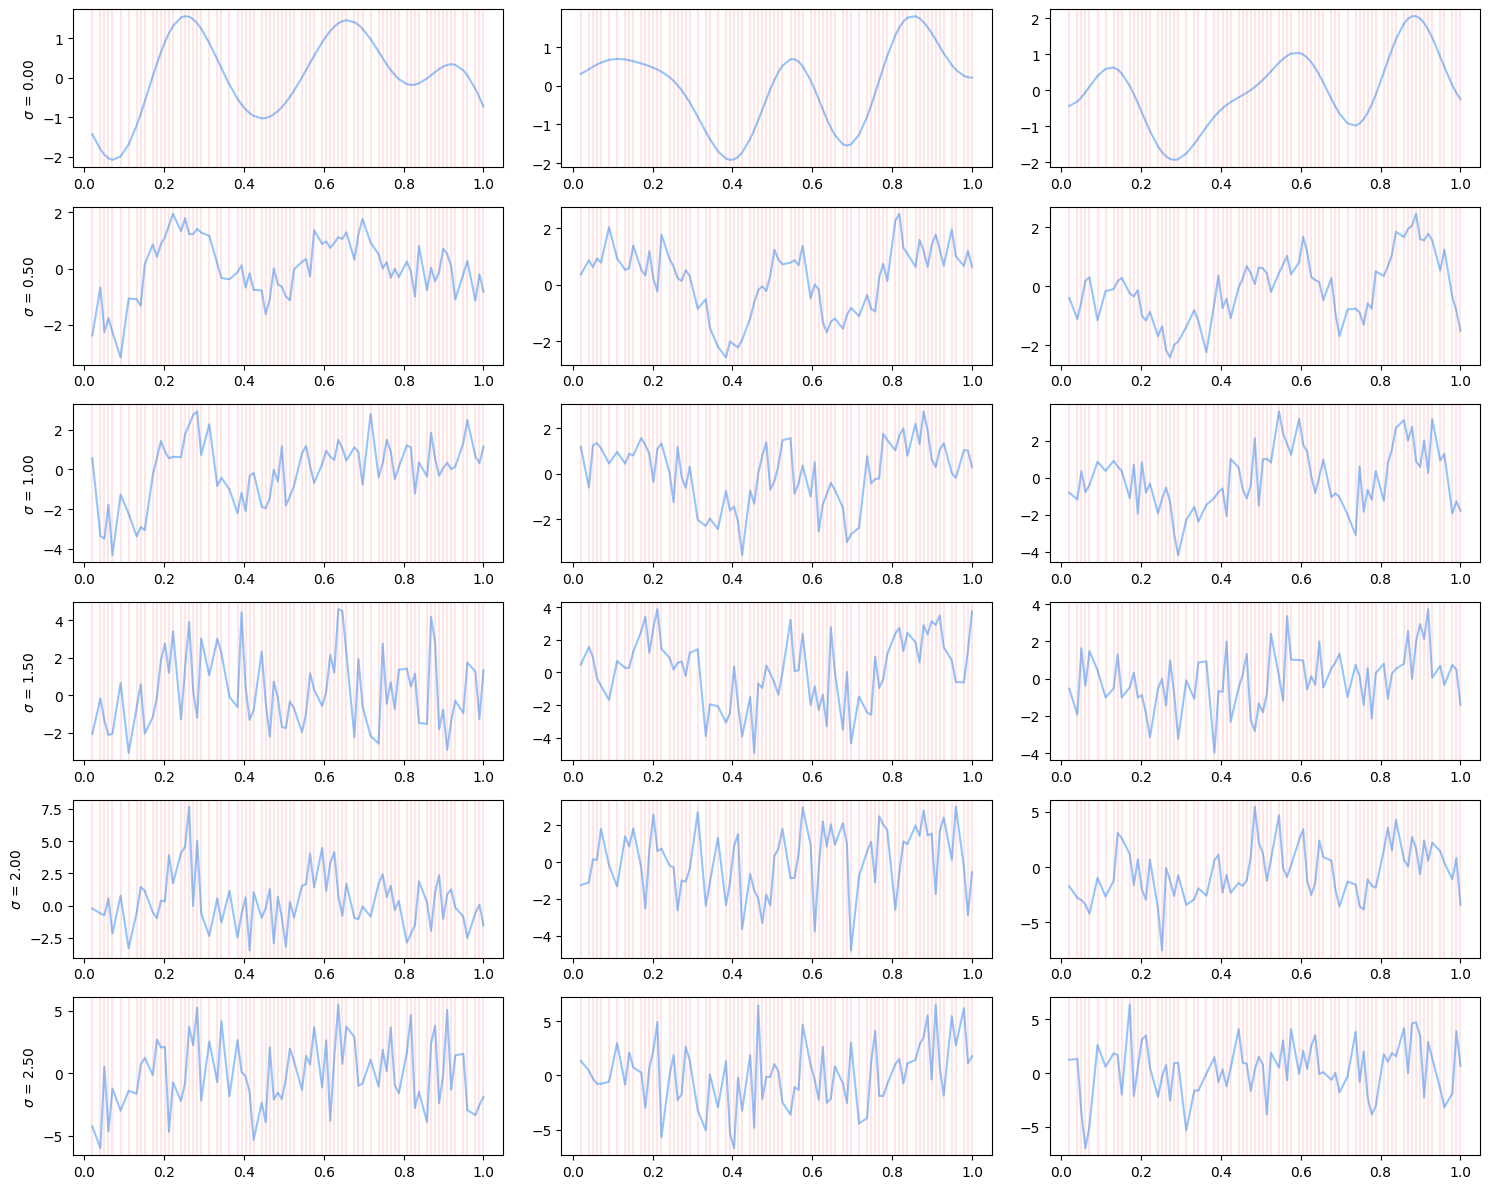

In [3]:

batch_size = 3
P_mean = -1.2 
P_std = 1.2
sigma_data = 0.5
steps = 6
torch.random.manual_seed(42)
#### 

dloader = DataLoader(dset, batch_size=batch_size, collate_fn=CompositeCollate([MakeConditional(), CollateMesh()]))
noising_kernel = RBFIrregular()
iterator = iter(dloader)
(coords, intensities), conditioning = next(iterator)

fig, axes = plt.subplots(steps, batch_size, figsize=(15, 2 * (steps)))
rnd_normal = torch.randn(batch_size).to(dtype=intensities.dtype).to(device=intensities.device)
sorted_sigma = rnd_normal.sort().values

for noise_scheduler, sigma_val in enumerate([0.0, 0.5, 1.0, 1.5, 2.0, 2.5]):
    sigma = torch.tensor(sigma_val).float().to(device=intensities.device).repeat(batch_size)  
    noised_out = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))
    
    for i in range(batch_size):
        ax = axes[noise_scheduler, i]
        ax.plot(coords.squeeze(), noised_out[i].squeeze())
        if i == 0:
            # set x - axis label
            ax.set_ylabel(f"$\\sigma$ = {sigma[i].item():.2f}")
        
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

plt.tight_layout()

Now let us train a single step denoiser that will revert a noising kernel. To do that, we would first create a dataset by sampling from the base process, apply a noising kernel on it, and then train a denoising operator based on the multipole architecture to invert that noising kernel. The following code does the training for such a neural operator:


In [5]:
noising_sigma = 0.5
num_epochs = 10
####

denoiser_network = MPGKScoreOperator(
    coord_dim=1,
    latent_channels=32,
    radius=0.01,
    radii_mult=[2, 4, 8],
    iter_count=3,
)
optim = torch.optim.Adam(denoiser_network.parameters(), lr=1e-3)
####


# TODO: fix Suppress all warnings
warnings.filterwarnings("ignore")
all_loss_history = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for (coords, intensities), conditioning in dloader:
        # zero grad
        optim.zero_grad()

        # sample noise
        sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size)
        noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))

        # train the model
        denoised = denoiser_network(
            coords=coords, 
            samples=noisy,
            sigma=torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size),
            conditioning=conditioning,
        )
        denoised = denoised.squeeze(-1)
        # compute loss
        loss = torch.nn.functional.mse_loss(denoised, intensities)
        all_loss_history.append(loss.item())

        # backprop
        loss.backward()
        optim.step()
        pbar.set_description(f"Loss: {loss.item():.3f}")


Loss: 0.085: 100%|██████████| 10/10 [02:21<00:00, 14.18s/it]


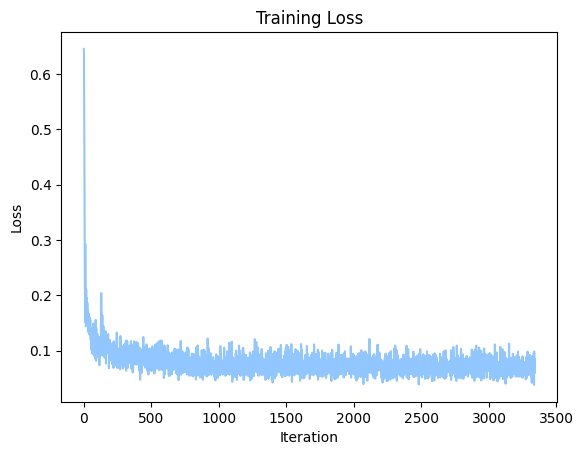

In [6]:
plt.plot(all_loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


Next, we test the denoising operator, and moreover, we test its irregular grid generalization. The following code tests the denoising operator on a grid complying with the original training discretization and a totally new irregular grid with higher resolution. You may also notice an extra saliency plot at the end, which shows the impotance of each region in the input function to the output of the denoising operator. The grid is somewhat diagonal, which means local interactions are more imporatant here. However, if one increases the scale of the noising kernel, the saliency map would become more uniform with more off-diagonal elements, showing that inverting a larger noise scale requires more global interactions.


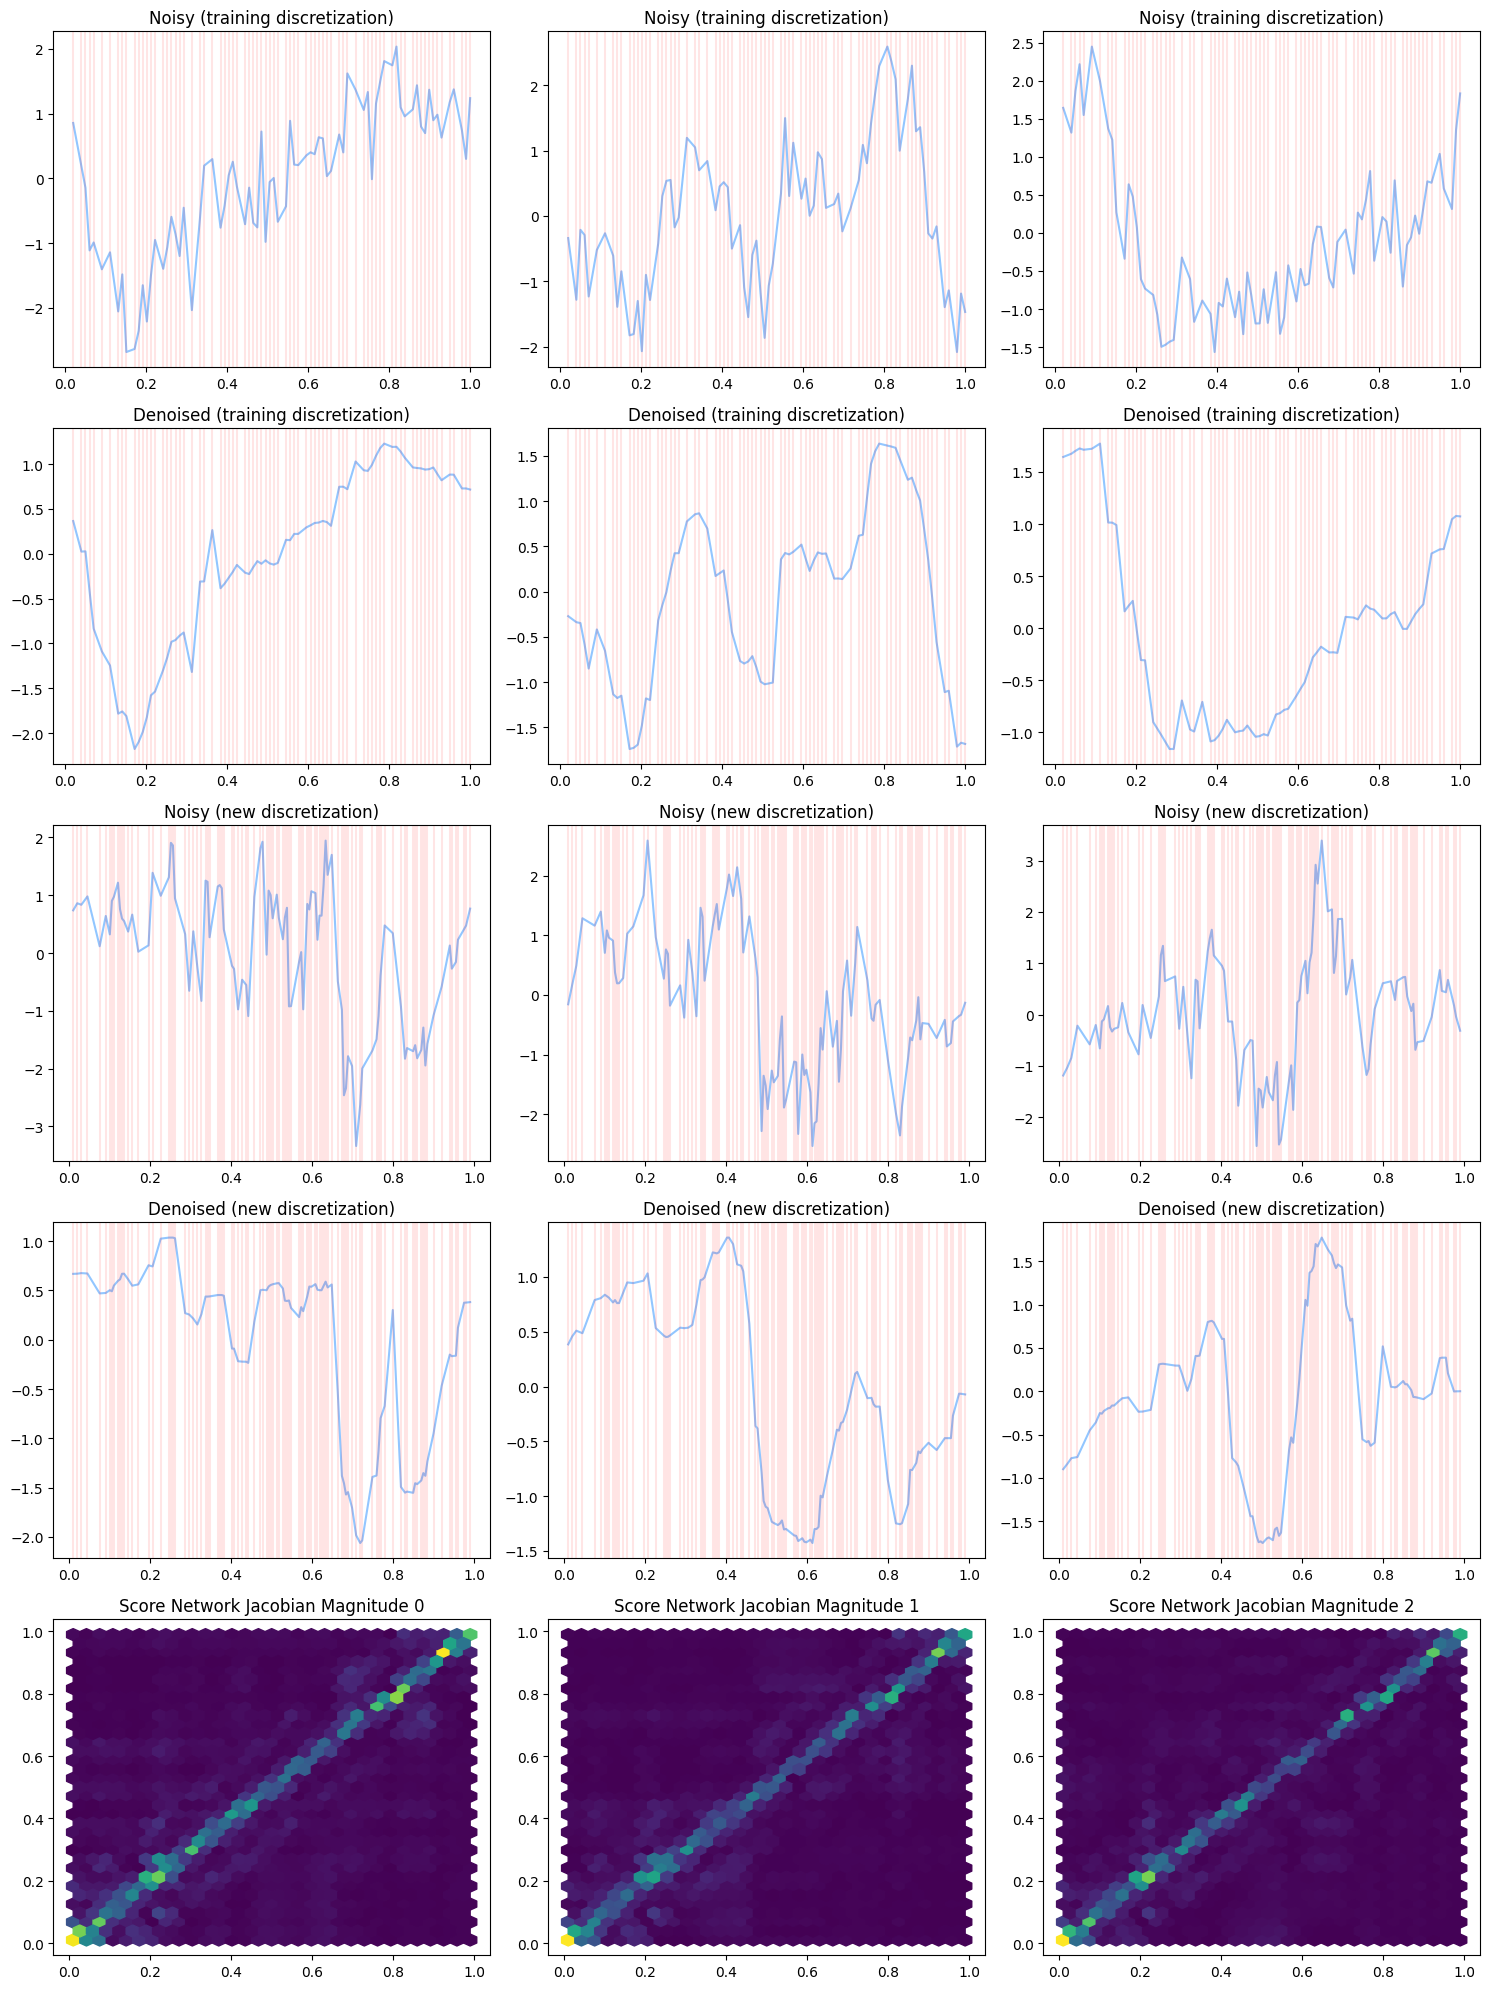

In [9]:
fig, axes = plt.subplots(5, 3, figsize=(15, 5 * 4))

(coords, intensities), conditioning = next(iter(dloader))

sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size)
noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(batch_size, 1, 1))

# try to denoise the noisy data from the training set
with torch.no_grad():
    denoised = denoiser_network(
        coords=coords, 
        samples=noisy, 
        sigma=torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size),
        conditioning=conditioning,
    )
    for i in range(batch_size):
        ax = axes[0, i]
        ax.plot(coords.squeeze(), noisy[i].squeeze())
        ax.set_title("Noisy (training discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)
        ax = axes[1, i]
        ax.plot(coords.squeeze(), denoised[i].squeeze())
        ax.set_title("Denoised (training discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

# sample data with totally different discretizations
ood_dset = PinkNoise1D(
    total_count=3,
    num_samples=200,
    low_pass_threshold=0.05,
    make_irregular=True,
    bernoulli_p=0.5,
    fixed_irregularity_seed=42,
)
ood_dloader = DataLoader(ood_dset, batch_size=3, collate_fn=CompositeCollate([MakeConditional(), CollateMesh()]))
(coords, intensities), conditioning = next(iter(ood_dloader))

sigma = torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(1)
noisy = intensities + sigma[:, None] * noising_kernel.sample(coords.unsqueeze(0).repeat(1, 1, 1))
denoised = denoiser_network(
        coords=coords, 
        samples=noisy, 
        sigma=torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size),
        conditioning=conditioning,
)

with torch.no_grad():
    for i in range(batch_size):
        ax = axes[2, i]
        ax.plot(coords.squeeze(), noisy[i].squeeze())
        ax.set_title("Noisy (new discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)
        ax = axes[3, i]
        ax.plot(coords.squeeze(), denoised[i].squeeze())
        ax.set_title("Denoised (new discretization)")
        # add small vertical lines on each coords 
        for x in coords.squeeze():
            ax.axvline(x, color="red", alpha=0.1)

# fine the Jacobian of denoised wrt noisy using torch.func.jacfwd
J = torch.autograd.functional.jacobian(
    functools.partial(
        denoiser_network,
        conditioning=conditioning,
        sigma=torch.tensor(noising_sigma).float().to(device=intensities.device).repeat(batch_size),
        conditioning_augmented=None,
    ), 
    inputs=(coords, noisy,),
    create_graph=True,
)
jacs = []
for i in range(batch_size):
    jacs.append(J[1][i, :, i, :].detach().squeeze().cpu())

meshgird = np.meshgrid(*[coords.squeeze().cpu().numpy() for _ in range(2)])
for i in range(batch_size):
    ax = axes[4, i]
    ax.set_title(f"Score Network Jacobian Magnitude {i}")
    ax.hexbin(
        x=meshgird[0].flatten(),
        y=meshgird[1].flatten(),
        C=jacs[i].abs().flatten(),
        gridsize=30,
    )


plt.tight_layout()